In [1]:
!pip install patchify

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random

In [4]:
minmaxscaler = MinMaxScaler()

In [5]:
!ls -lah '/content/drive/MyDrive/Semantic segmentation dataset'

total 33K
-rw------- 1 root root  548 Jan 18 14:00  classes.json
drwx------ 2 root root 4.0K Jan 18 14:00 'Tile 1'
drwx------ 2 root root 4.0K Jan 18 14:00 'Tile 2'
drwx------ 2 root root 4.0K Jan 18 14:00 'Tile 3'
drwx------ 2 root root 4.0K Jan 18 14:00 'Tile 4'
drwx------ 2 root root 4.0K Jan 18 14:00 'Tile 5'
drwx------ 2 root root 4.0K Jan 18 14:00 'Tile 6'
drwx------ 2 root root 4.0K Jan 18 14:00 'Tile 7'
drwx------ 2 root root 4.0K Jan 18 14:00 'Tile 8'


In [6]:
dataset_root_folder = '/content/drive/MyDrive'

In [7]:
dataset_name = 'Semantic segmentation dataset'

In [8]:
for path, subdirs, files in os.walk(os.path.join(dataset_root_folder, dataset_name)):
  dir_name = path.split(os.path.sep)[-1]
  #print(dir_name)
  if dir_name == 'masks':
    images = os.listdir(path)
    print(path)
    #print(images)
    for i, image_name in enumerate(images):
      if (image_name.endswith('.png')):
        #print(image_name)
        a = True

/content/drive/MyDrive/Semantic segmentation dataset/Tile 3/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 5/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 6/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 4/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 8/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 7/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 2/masks
/content/drive/MyDrive/Semantic segmentation dataset/Tile 1/masks


In [9]:
image_patch_size = 256

In [10]:
#image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile 1/images/image_part_001.jpg',1)

In [11]:
#image.shape

In [12]:
image_dataset = []
mask_dataset = []

for tile_id in range(1, 8):
    for image_id in range(1, 10):
        for image_type in ['images', 'masks']:
            if image_type == 'images':
                image_extension = 'jpg'
            elif image_type == 'masks':
                image_extension = 'png'

            file_path = f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}'
            # print(f"Trying to read: {file_path}")
            image = cv2.imread(file_path, 1)
            if image is not None:
                if image_type == 'masks':
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # print(f"Image shape: {image.shape}")
                size_x = (image.shape[1] // image_patch_size) * image_patch_size
                size_y = (image.shape[0] // image_patch_size) * image_patch_size
                # print("{} ---- {} - {}".format(image.shape, size_x, size_y))
                image = Image.fromarray(image)
                image = image.crop((0, 0, size_x, size_y))
                image = np.array(image)
                patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
                for i in range(patched_images.shape[0]):
                    for j in range(patched_images.shape[1]):
                        if image_type == 'images':
                            individual_patched_image = patched_images[i, j, :, :]
                            # print(individual_patched_image.shape)
                            individual_patched_image = minmaxscaler.fit_transform(
                                individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(
                                individual_patched_image.shape)
                            individual_patched_image = individual_patched_image[0]
                            # print(individual_patched_image.shape)
                            image_dataset.append(individual_patched_image)
                        elif image_type == 'masks':
                            individual_patched_mask = patched_images[i, j, :, :]
                            individual_patched_mask = individual_patched_mask[0]
                            mask_dataset.append(individual_patched_mask)
            else:
                print(f"Error reading image: {file_path}")

print(len(image_dataset))
print(len(mask_dataset))


945
945


In [13]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [14]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


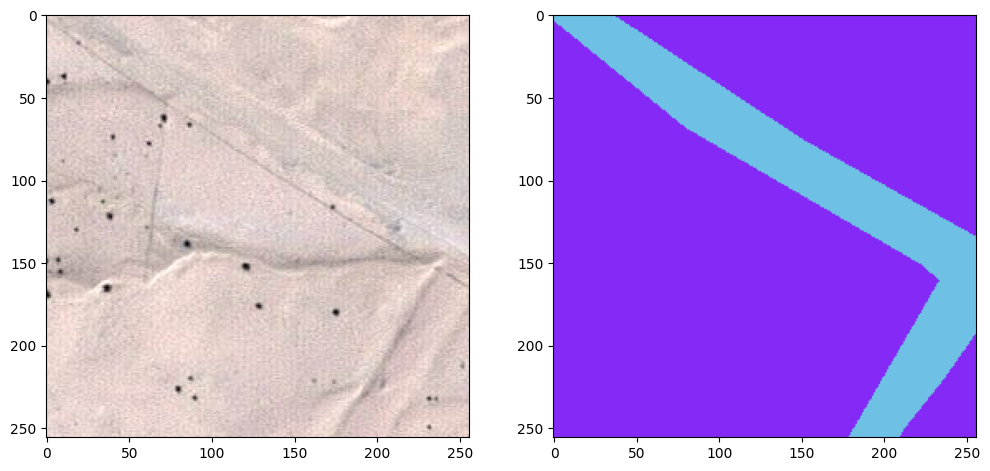

In [15]:
random_image_id = random.randint(0, len(image_dataset))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [16]:
#Processing mask image labels
class_building = '#3C1098'
class_building = tuple(int(class_building.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

(60, 16, 152)
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [19]:
label = individual_patched_mask

In [20]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  label_segment = label_segment[:,:,0]
  return label_segment

In [21]:
#The labelled data belong to the masked dataset
#Creating a method which takes the RGB value and convert it into 2D label
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [22]:
labels = np.expand_dims(labels, axis=3)

In [23]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

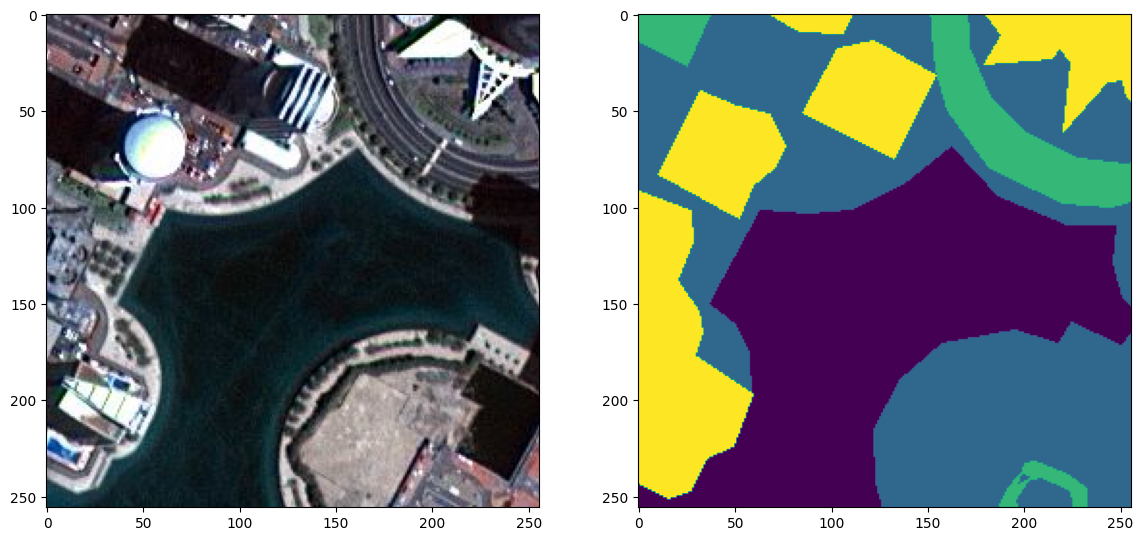

In [24]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(labels[random_image_id][:,:,0])

In [25]:
master_training_dataset = image_dataset
from sklearn.model_selection import train_test_split

In [26]:
total_classes = len(np.unique(labels))

In [27]:
from tensorflow.keras.utils import to_categorical

In [28]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)
labels_categorical_dataset.shape

(945, 256, 256, 6)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(master_training_dataset, labels_categorical_dataset, test_size = 0.15, random_state=100)

In [30]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [33]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [34]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6
